# Definition of Distribution A
## Setup

In [66]:
from datetime import datetime as dt
from dill import dump
from matplotlib import pyplot as plot
from random import uniform
from sympy import Symbol, integrate, lambdify, solve

from LocUtil import Grid1, SetSeed

Define constants

In [67]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101

fileName = '..\dist_a.dill'

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
F:\Users\Kenne.DESKTOP-BT6VROU\AppData\Local\Temp\ipykernel_13368\887713665.py:8: SyntaxWarning: invalid escape sequence '\d'
  fileName = '..\dist_a.dill'


Define Symbols

In [68]:
xSym = Symbol('x')    # the random variable

aSym = Symbol('a')    # the probability at x=0
bSym = Symbol('b')    # the probability at x=1

qSym = Symbol('q')    # the quantile

## Define Elements of the Distribution
#### The PDF

In [69]:
form = aSym * (1 - xSym) + bSym * xSym
form

a*(1 - x) + b*x

To be a distribution the total probabilities must be one.  This implies that `a` and `b` are 
dependent.  Solve for `b` and express the distribution only in terms of `a`.

In [70]:
area = integrate(form, (xSym,0,1))
bExp = solve(area - 1, bSym)[0]
bExp

2 - a

Because both `a` and `b` must be non-negative, the range of `a` and `b` is (0,2).

In [71]:
form.subs(bSym, bExp).simplify()

-2*a*x + a + 2*x

In [72]:
pdfSym = 2*(1 - aSym) * xSym + aSym
pdfSym

a + x*(2 - 2*a)

In [73]:
Pdf = lambdify((xSym,a), pdfSym.subs(aSym,a).simplify())

SyntaxError: invalid syntax (<lambdifygenerated-29>, line 1)

In [74]:
def PdfFact(a):
	

SyntaxError: incomplete input (2633257662.py, line 2)

In [75]:
aL = Grid1(0,2,5)
xGrid = Grid1(0,1, nPlot)

for a in aL:
	pdfGrid = [pdf(x,a) for x in xGrid]
	plot.plot(xGrid,pdfGrid)

TypeError: _lambdifygenerated() takes 1 positional argument but 2 were given

#### The CDF

In [76]:
cdfSym = integrate(pdfSym,xSym)
cdfSym

a*x + x**2*(1 - a)

In [77]:
def CdfFact(a):
	return lambdify(xSym, cdfSym.subs(aSym, a).simplify())

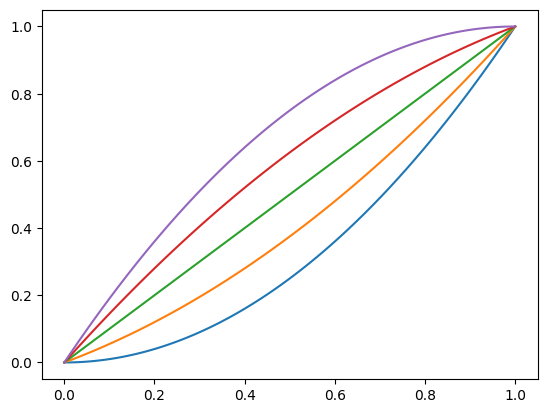

In [78]:
for a in aL:
	cdf = CdfFact(a)
	cdfGrid = [cdf(x) for x in xGrid]
	plot.plot(xGrid,cdfGrid)

#### Inverse CDF

In [79]:
temp = solve(cdfSym - qSym, xSym)
temp

[(a - sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1)),
 (a + sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))]

In [80]:
invCdfSym = temp[0]
invCdfSym

(a - sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))

There is a removable singularity at a = 1 ... need a library function for dealing with removable singularities. Would need to specify the required accuracy at the transition.

In [81]:
approxAt1 = invCdfSym.series(aSym,1).simplify().removeO()
approxAt1

q + (a - 1)**5*(21*(2*q - 1)**6 - 35*(2*q - 1)**4 + 15*(2*q - 1)**2 - 1)/32 + (a - 1)**4*(6*q + 7*(2*q - 1)**5 - 10*(2*q - 1)**3 - 3)/16 + (a - 1)**3*(5*(2*q - 1)**4 - 6*(2*q - 1)**2 + 1)/16 + (a - 1)**2*(-2*q + (2*q - 1)**3 + 1)/4 + (a - 1)*((2*q - 1)**2 - 1)/4

In [82]:
def InvCdfFact(a):
	if abs(a - 1) < 0.01:
		result = approxAt1.subs(aSym,a)
	else:
		result = invCdfSym.subs(aSym, a).simplify()
	  
	return lambdify(qSym, result)

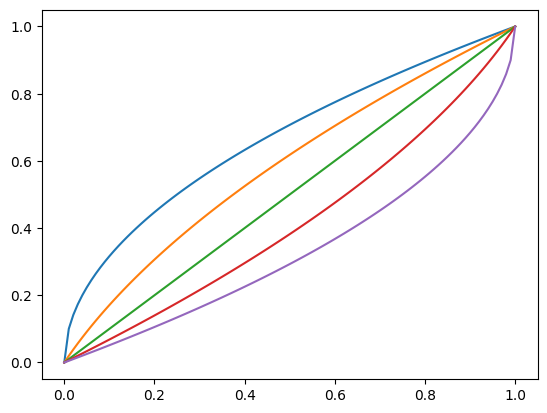

In [83]:
qGrid = Grid1(0,1, nPlot)

for a in aL:
	invCdf = InvCdfFact(a)
	invCdfGrid = [invCdf(x) for x in xGrid]
	plot.plot(xGrid,invCdfGrid)

## Sample Generation

In [84]:
def GenSamp(a, nSamp):
	sampCdf = [uniform(0,1) for _ in range(nSamp)]
	invCdf = InvCdfFact(a)
	x = [invCdf(q) for q in sampCdf]
	
	return x

In [85]:
seed = SetSeed(givenSeed, seedDig)
seed

610

In [86]:
a = uniform(0,2)
a

0.8896438391139418

Text(0.5, 1.0, 'a = 0.89')

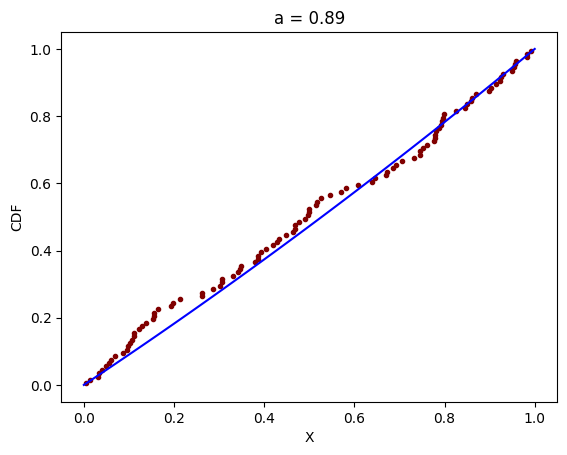

In [87]:
sampSort = sorted(GenSamp(a,nSamp))
quant = [(k + 0.5) / nSamp for k in range(nSamp)]

plot.plot(sampSort,quant, '.', c="Maroon")

xGrid = Grid1(0,1, nPlot)
qGrid = [cdfSym.subs(aSym,a).subs(xSym,x) for x in xGrid]
plot.plot(xGrid,qGrid, c='Blue')

plot.xlabel('X')
plot.ylabel('CDF')
plot.title(f'a = {a:.2f}')

## Save Results for Reuse

In [88]:
class DistA:
	xSym = xSym	
	aSym = aSym

	pdfSym = pdfSym
	cdfSym = cdfSym
	invCdfSym = invCdfSym
	
	PdfNum = lambdify((xSym, aSym), pdfSym.simplify())
	CdfNum = lambdify((xSym, aSym), pdfSym.simplify())
	CdfInvNum = lambdify((xSym, aSym), pdfSym.simplify())
	
	def PdfFact(self, a):
		return lambdify(xSym, pdfSym.subs(aSym,a).simplify())
	def CdfFact(self, a):
		return lambdify(xSym, cdfSym.subs(aSym,a).simplify())
	def InvCdfFact(self, a):
		return lambdify(xSym, invCdfSym.subs(aSym,a).simplify())

In [89]:
with open(fileName, 'wb') as file:
	dump(DistA, file)

In [90]:
print(dt.now())

2024-06-18 19:22:20.613895
